# Overview : YOLOV8 Molde Fine-Tuning on Blood Cancer Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.5/691.5 kB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install  opencv-python-headless

In [ ]:
#import some necessary librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
from random import sample

#deep learning
import torch
import cv2

# Constants

In [ ]:
# Reproducibility
RANDOM_SEED = 42

#Directories
PROJECT_PATH = "/content/drive/MyDrive/projects/blood_cancer_project"
YOLO_DATASET_PATH="/content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer"

CONFIDENCE_TRESHOLD = 0.75
IOU_TRESHOLD = 0.8

In [ ]:
sns.set_theme()

In [ ]:
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

# Read And Preapare Data For Model

In [ ]:
import yaml

data_yaml = dict(
    train=f'{YOLO_DATASET_PATH}/images/train',
    val=f'{YOLO_DATASET_PATH}/images/val',
    test=f'{YOLO_DATASET_PATH}/images/test',
    nc=2,
    names=['0' ,"1"]
)


with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=False)

In [ ]:
def parse_segmentation_labels(label_path, img_width, img_height):
    with open(label_path, 'r') as file:
        masks = []
        for line in file:
            points = line.split()[1:]
            points = list(map(float, points))
            polygon = np.array([(int(p[0] * img_width), int(p[1] * img_height)) for p in zip(points[0::2], points[1::2])])
            mask = np.zeros((img_height, img_width), dtype=np.uint8)
            cv2.fillPoly(mask, [polygon], 255)
            masks.append(mask)
    return masks

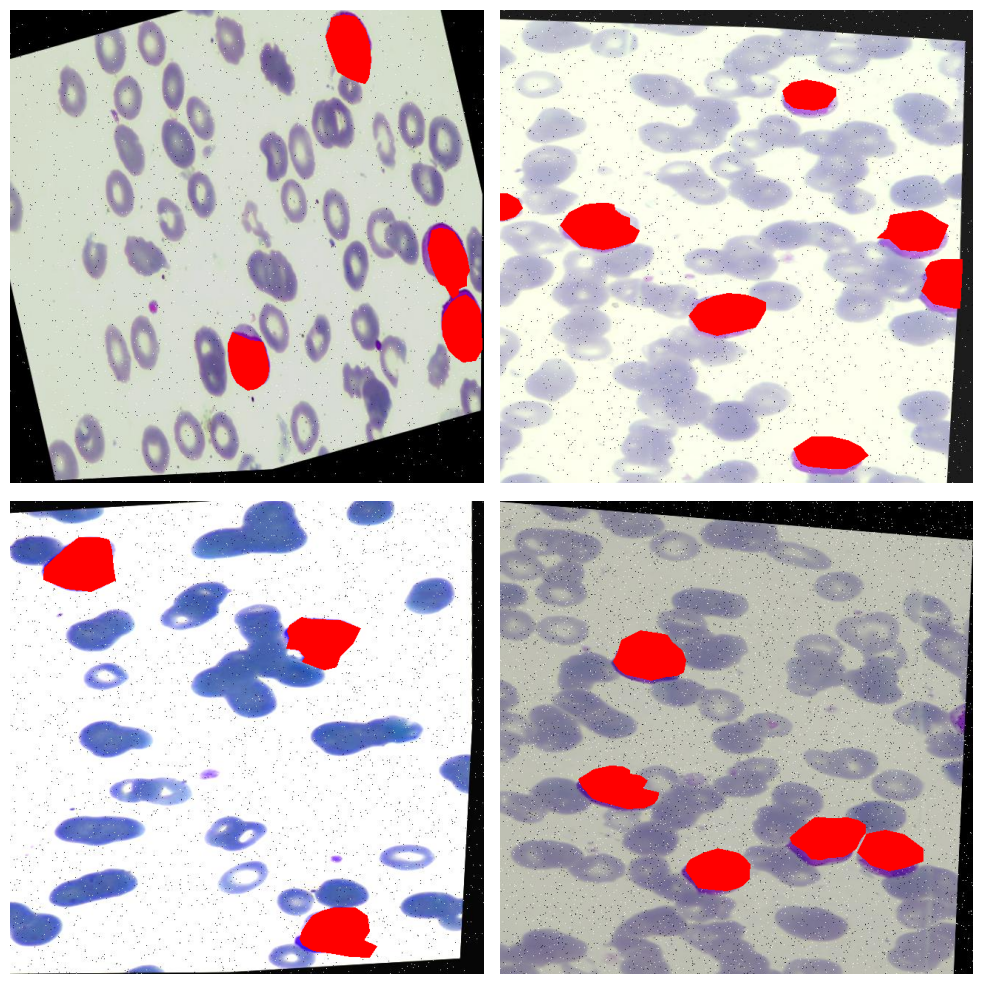

In [ ]:

def load_image_with_masks(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]

    masks = parse_segmentation_labels(label_path, img_width, img_height)
    return image, masks


dataset_dir = YOLO_DATASET_PATH
image_dir = os.path.join(dataset_dir, 'images/train')
label_dir = os.path.join(dataset_dir, 'labels/train')

image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

num_samples = min(4, len(image_files))
selected_images = sample(image_files, num_samples)

grid_size = int(np.ceil(np.sqrt(num_samples)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for ax in axes.flatten()[num_samples:]:
    ax.axis('off')

for ax, img_path in zip(axes.flatten(), selected_images):
    label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
    image, masks = load_image_with_masks(img_path, label_path)

    for mask in masks:
        image[mask == 255] = [255,0,0]

    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

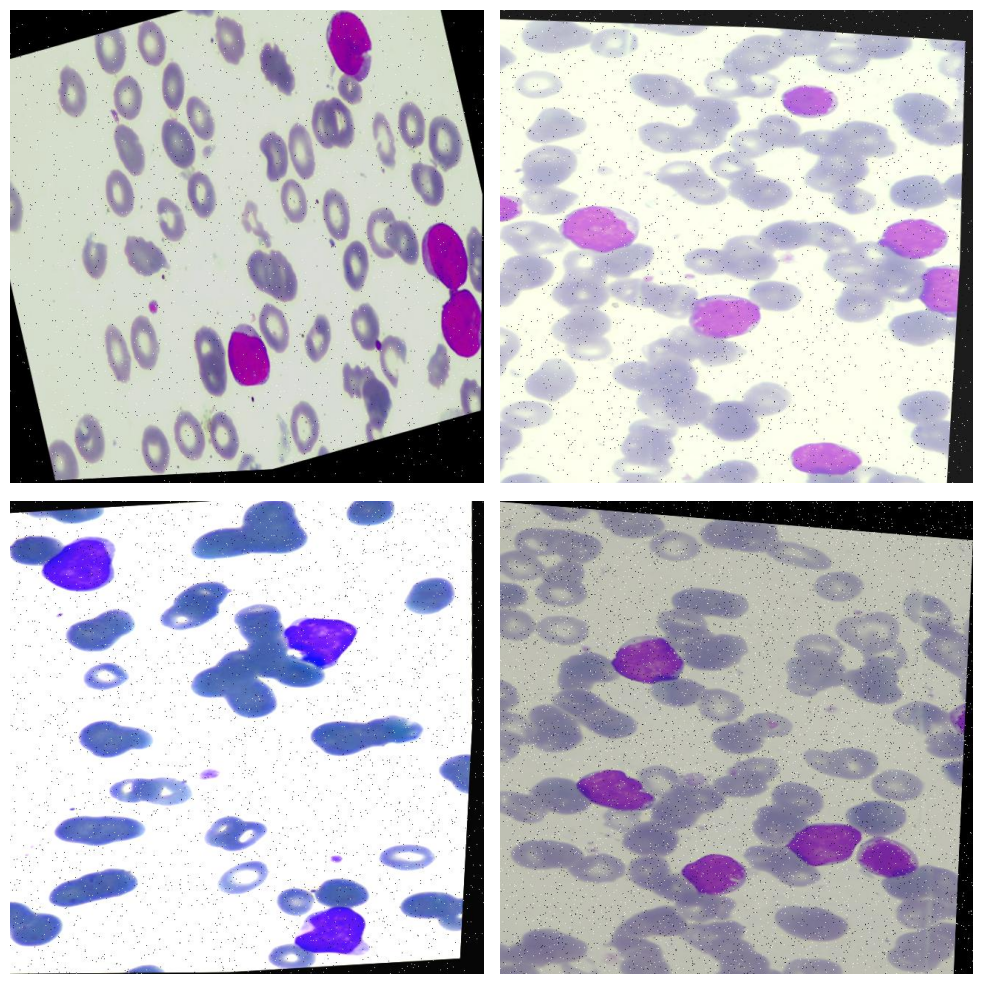

In [ ]:
grid_size = int(np.ceil(np.sqrt(num_samples)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for ax in axes.flatten()[num_samples:]:
    ax.axis('off')

for ax, img_path in zip(axes.flatten(), selected_images):
    label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
    image, masks = load_image_with_masks(img_path, label_path)
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Build and Train YOLOV8 Model

In [ ]:
from ultralytics import YOLO

# load model
model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')

# train model
results = model.train(data='data.yaml', epochs=100, imgsz=640)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 68.3MB/s]


Transferred 355/417 items from pretrained weights
Ultralytics YOLOv8.0.236 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

100%|██████████| 755k/755k [00:00<00:00, 24.2MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer/labels/train... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:53<00:00,  2.69it/s]

train: New cache created: /content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer/labels/val... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]

val: New cache created: /content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer/labels/val.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.533G      1.273      8.564      3.607      1.263        146        640:  11%|█         | 1/9 [00:06<00:49,  6.20s/it]Exception in thread Thread-26 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/utils/plotting.py", line 637, in plot_images
    conf = confs[idx] if confs is not None else None  # check for confidence presence (label vs pred)
IndexError: The shape of the mask [146] at index 0 does not match the shape of the indexed tensor [16, 160, 160] at index 0
      1/100      3.38G      1.253      8.729      3.635      1.234        180        640:  33%|███▎      | 3/9 [00:07<00:10,  1.82s/it]Exception in thread Thread-27 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", l

                   all         14         94    0.00455      0.216    0.00506    0.00141          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.49G      1.295      4.496      3.064      1.231        187        640: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         14         94     0.0197      0.853      0.383      0.278          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.54G      1.369      3.222      2.039      1.177        147        640: 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         14         94      0.437      0.933      0.581      0.418       0.24      0.507      0.248     0.0378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.36G      1.276      2.715      1.681      1.127        142        640: 100%|██████████| 9/9 [00:04<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         14         94      0.427      0.884        0.5      0.336      0.418      0.866      0.474      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.49G      1.266      2.466      1.575       1.12        163        640: 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         14         94      0.503      0.606      0.515      0.375      0.493      0.609      0.521      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.39G      1.222      2.441      1.518       1.13        181        640: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         14         94      0.384      0.875      0.451      0.337      0.379      0.881      0.455      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.29G      1.207        2.3      1.518      1.133        123        640: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         14         94       0.48      0.778      0.588      0.427      0.485      0.796      0.594      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.26G      1.221      2.239       1.43      1.122        152        640: 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         14         94      0.501       0.39      0.508      0.386      0.501       0.39      0.512      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.27G      1.234      2.208      1.415      1.107        139        640: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         14         94      0.565      0.427      0.548      0.415      0.565      0.427      0.548      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100       3.6G      1.211      2.174      1.405        1.1        185        640: 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         14         94      0.499       0.92       0.59      0.443      0.499       0.92      0.591      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.34G      1.217      2.119      1.336      1.098        148        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         14         94      0.479       0.93      0.588      0.458      0.479       0.93       0.59      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.44G      1.287      2.166      1.366      1.112        143        640: 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         14         94      0.487       0.96      0.606      0.465      0.487       0.96      0.608      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.48G      1.243      2.175       1.35      1.112        220        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         14         94      0.571      0.893      0.648      0.504      0.571      0.893      0.654      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.4G      1.214      2.062      1.296      1.085        129        640: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         14         94      0.557      0.707      0.689      0.516      0.557      0.707      0.692      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.5G      1.274      2.148      1.247      1.112        167        640: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         14         94      0.564      0.884      0.775      0.608      0.564      0.884      0.779      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.33G      1.215      2.112      1.222      1.109        214        640: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         14         94      0.695      0.799      0.806      0.621      0.695      0.799      0.808      0.614



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.24G      1.296       2.11      1.265      1.158        178        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         14         94       0.63       0.85      0.764      0.604       0.63       0.85      0.764      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100       3.3G      1.215      2.093      1.174      1.104        245        640: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         14         94       0.63      0.836      0.722      0.563       0.63      0.836      0.722      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100       3.3G      1.199      2.058      1.157      1.107        217        640: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         14         94      0.556      0.844      0.752       0.59      0.556      0.844      0.756      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100       3.4G       1.26       2.11      1.169        1.1        170        640: 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         14         94        0.6      0.826      0.714      0.562      0.606      0.839      0.718      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.36G      1.208      2.025       1.13      1.091        234        640: 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         14         94      0.689      0.815      0.835      0.652      0.689      0.815      0.842        0.6



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.24G      1.222      2.058      1.072      1.085        163        640: 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         14         94      0.766       0.83      0.845      0.666      0.762      0.854      0.844      0.623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.25G      1.191      1.981      1.089      1.104        218        640: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         14         94       0.86       0.89      0.916      0.696       0.86       0.89      0.915      0.678



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.42G      1.133      2.025      1.058      1.075        175        640: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         14         94       0.65      0.854      0.845      0.662       0.65      0.854      0.849      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.41G       1.18      1.974      1.025      1.094        174        640: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         14         94      0.691      0.938      0.879      0.674      0.691      0.938      0.884      0.675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.24G      1.171      1.998      1.013      1.096        156        640: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         14         94      0.801      0.785      0.813      0.628      0.801      0.785      0.817      0.616



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.27G       1.14      1.954     0.9777      1.079        155        640: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         14         94      0.831      0.757      0.843      0.663      0.831      0.757      0.846      0.632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.31G      1.198      2.057     0.9578      1.092        174        640: 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         14         94      0.734      0.795      0.825      0.647      0.734      0.795      0.825      0.594



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.26G      1.126      1.886     0.9467      1.076        123        640: 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         14         94      0.721      0.781      0.836      0.664      0.721      0.781       0.84      0.625



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.22G      1.177      2.014     0.9166      1.077        160        640: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         14         94      0.816      0.823       0.88      0.704      0.816      0.823      0.884      0.666



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.26G      1.139      1.906     0.9218      1.064        166        640: 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         14         94      0.768      0.828      0.887      0.713      0.768      0.828      0.892       0.67



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.32G       1.19       1.98     0.9664      1.091        152        640: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         14         94      0.701      0.828      0.821      0.641      0.701      0.828      0.825      0.623



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.46G       1.15      1.956     0.9149      1.063        147        640: 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         14         94      0.762      0.889      0.899      0.694      0.762      0.889      0.902      0.689



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.37G      1.143      1.935     0.8852      1.064        142        640: 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         14         94      0.841      0.835      0.925      0.727      0.841      0.835      0.927      0.702



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.3G      1.109      1.832     0.8842       1.05        190        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         14         94      0.844      0.885      0.941      0.748      0.844      0.885      0.944      0.713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.38G      1.098      1.841     0.8761      1.037        209        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         14         94      0.725      0.806      0.924      0.747      0.737      0.822      0.931      0.716



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.33G      1.046      1.777     0.8445      1.037        145        640: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         14         94      0.645      0.751      0.832       0.66       0.66      0.759      0.844      0.641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.36G      1.109      1.867     0.8349      1.054        168        640: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         14         94      0.613      0.846      0.872      0.706      0.623      0.856      0.886      0.683



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.36G      1.075      1.809     0.8358      1.038        217        640: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         14         94      0.743       0.87      0.846       0.67      0.728      0.873      0.857      0.645



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.36G      1.117      1.845     0.8606      1.055        185        640: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         14         94      0.755      0.886      0.902      0.716       0.76      0.899      0.915      0.698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.35G      1.015      1.719     0.7926      1.016        202        640: 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         14         94      0.861      0.829       0.93      0.753      0.861      0.829      0.939      0.735



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.59G      1.109      1.852     0.8116      1.063        181        640: 100%|██████████| 9/9 [00:04<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         14         94      0.708      0.767      0.773      0.607      0.708      0.767      0.784      0.602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.28G      1.121      1.917     0.8233      1.068        166        640: 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         14         94      0.851      0.775      0.874      0.708      0.851      0.775      0.882      0.679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.48G       1.09      1.842     0.8177      1.046        186        640: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         14         94      0.806      0.824      0.902      0.737      0.806      0.824      0.906       0.71



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.27G      1.047      1.814     0.8494       1.04        142        640: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         14         94      0.735      0.923      0.911      0.734      0.735      0.923      0.918      0.719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.32G      1.123      1.874     0.8556      1.065        238        640: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         14         94      0.864      0.851      0.923      0.734      0.864      0.851      0.931      0.731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.37G      1.059      1.816     0.8303      1.039        153        640: 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         14         94      0.829      0.815      0.895      0.726      0.829      0.815      0.902      0.701



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.25G      1.052      1.722     0.7449      1.028        169        640: 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         14         94      0.732      0.707      0.721      0.587      0.732      0.707      0.721      0.562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.24G      1.079       1.76     0.7606      1.034        176        640: 100%|██████████| 9/9 [00:04<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         14         94      0.704      0.853      0.862       0.71      0.716      0.862      0.872      0.673



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.44G      1.044      1.689     0.7209      1.022        205        640: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         14         94      0.894      0.875      0.953      0.777      0.894      0.875      0.959       0.75



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100       3.4G       1.08      1.792     0.7758      1.058        171        640: 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         14         94       0.73      0.873      0.921      0.734       0.74      0.881      0.928      0.699



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100       3.4G       1.07      1.766     0.7598      1.047        167        640: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         14         94      0.688      0.702       0.66      0.521      0.688      0.702       0.66      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.39G      1.033      1.694     0.7178       1.01        199        640: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         14         94      0.701      0.791      0.816      0.667      0.701      0.791      0.816      0.638



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.29G      1.043       1.71     0.7233      1.033        173        640: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         14         94      0.908      0.861      0.957      0.769      0.908      0.861      0.957      0.758



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.58G      1.033      1.674     0.7467      1.022        150        640: 100%|██████████| 9/9 [00:04<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         14         94      0.866      0.856       0.93      0.738      0.866      0.856       0.93      0.719



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.31G     0.9922      1.642     0.6986      1.003        189        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         14         94      0.813       0.85      0.857      0.677      0.813       0.85      0.857      0.675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.26G      1.008      1.675      0.716      1.007        136        640: 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         14         94      0.822      0.906      0.917      0.741      0.822      0.906      0.917      0.722



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100       3.6G     0.9903      1.582     0.7073      1.006        164        640: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         14         94      0.805      0.965      0.939      0.751      0.805      0.965      0.944      0.747



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.49G      1.009      1.641     0.7123      1.008        152        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         14         94      0.953      0.877      0.954      0.763      0.953      0.877      0.961      0.762



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.33G     0.9957      1.637     0.6784     0.9929        188        640: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         14         94       0.94      0.943      0.967      0.784       0.94      0.943      0.972      0.753



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.47G      1.031      1.677     0.7038       1.02        193        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         14         94      0.934      0.915      0.969      0.785      0.934      0.915      0.977      0.764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.31G     0.9937      1.634     0.6668      1.022        165        640: 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         14         94      0.806      0.926      0.962      0.783      0.806      0.926      0.963      0.745



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.79G      1.022      1.625     0.7052      1.015        130        640: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         14         94      0.918      0.837      0.957      0.771      0.918      0.837      0.957       0.76



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.52G     0.9639      1.571     0.6583      1.009        146        640: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         14         94      0.849      0.853      0.946      0.759      0.849      0.853      0.946      0.744



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.33G     0.9075      1.479     0.6557     0.9901        159        640: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         14         94      0.819      0.843       0.88      0.715      0.819      0.843       0.88      0.692



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.43G     0.9809      1.578     0.6591      1.006        129        640: 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         14         94      0.858      0.837      0.914      0.744      0.858      0.837       0.92      0.713



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.53G     0.9781      1.594     0.6544     0.9993        226        640: 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         14         94      0.861      0.842      0.907      0.723      0.861      0.842      0.916      0.706



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.33G     0.9342      1.558     0.6627     0.9874        149        640: 100%|██████████| 9/9 [00:04<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         14         94      0.902      0.801      0.948      0.769      0.902      0.801      0.957      0.749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.58G     0.9667      1.559     0.6496      1.001        131        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         14         94       0.92      0.906      0.963      0.781      0.898       0.94      0.968      0.763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.43G     0.9312      1.541     0.6289     0.9786        181        640: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         14         94      0.893      0.947       0.96      0.782      0.901      0.956      0.971      0.764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.34G     0.9078      1.495     0.6424     0.9825        148        640: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         14         94      0.863      0.766      0.906      0.736      0.863      0.766      0.917      0.725



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.26G     0.9765      1.557     0.6936      1.011        229        640: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         14         94      0.839      0.842      0.928      0.755      0.839      0.842      0.936      0.742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.4G     0.9487      1.529     0.6574     0.9877        198        640: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         14         94       0.98      0.938      0.971      0.796       0.98      0.938      0.979      0.784



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.29G     0.9304      1.488     0.6318      0.982        186        640: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         14         94      0.984      0.923      0.972      0.788      0.984      0.923      0.982      0.774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.46G     0.9315      1.546      0.661     0.9891        172        640: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         14         94      0.977      0.943      0.972      0.793      0.977      0.943       0.98      0.771



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.38G     0.8982      1.485     0.6116     0.9693        185        640: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         14         94      0.864      0.924      0.943      0.767      0.864      0.924      0.951      0.754



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.35G     0.8938      1.452     0.6199     0.9736        177        640: 100%|██████████| 9/9 [00:03<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         14         94      0.899      0.863      0.926       0.75      0.899      0.863      0.935       0.74



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.28G     0.9152      1.454     0.6174     0.9802        156        640: 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         14         94      0.849      0.876      0.928       0.75      0.849      0.876      0.935      0.738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.48G     0.9646      1.555     0.6227     0.9997        150        640: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         14         94      0.843      0.864      0.911      0.743      0.843      0.864      0.919       0.73



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.32G     0.9349      1.481      0.619     0.9881        149        640: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         14         94      0.836      0.852      0.908      0.751      0.836      0.852      0.916      0.726



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100       3.5G     0.9373      1.533      0.619     0.9716        183        640: 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         14         94      0.851      0.872      0.899      0.736      0.851      0.872      0.906       0.72



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100       3.3G     0.9291      1.493     0.6373     0.9764        187        640: 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         14         94      0.877      0.822      0.881      0.723      0.877      0.822      0.886      0.711



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.32G     0.9289      1.502     0.6109      0.988        173        640: 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         14         94      0.812      0.829      0.908      0.738      0.812      0.829      0.909      0.732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.49G     0.8697      1.426     0.6137     0.9628        201        640: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         14         94      0.928      0.884      0.967      0.776      0.928      0.884      0.968      0.767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.39G     0.8546      1.388     0.5928     0.9413        174        640: 100%|██████████| 9/9 [00:04<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         14         94      0.922      0.905      0.955       0.77      0.922      0.905      0.963      0.756



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.44G     0.8335      1.375     0.5669     0.9546        154        640: 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         14         94      0.857      0.903      0.949      0.768      0.857      0.903      0.958      0.765



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.28G     0.9026       1.45     0.5837     0.9732        175        640: 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         14         94      0.913      0.913      0.959      0.774      0.913      0.913      0.966      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.49G     0.8548       1.38      0.569      0.954        175        640: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         14         94      0.925      0.838      0.941      0.767      0.925      0.838      0.951      0.761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.27G     0.8976      1.477     0.6293     0.9727        172        640: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         14         94      0.885      0.863      0.934      0.764      0.885      0.863      0.944      0.751



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.43G     0.8739      1.441     0.5774     0.9651        182        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         14         94      0.894      0.863      0.951      0.776      0.894      0.863      0.961      0.767


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.15G     0.9133      1.549     0.6184      0.966        120        640:  11%|█         | 1/9 [00:01<00:08,  1.05s/it]Exception in thread Thread-39 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/utils/plotting.py", line 637, in plot_images
    conf = confs[idx] if confs is not None else None  # check for confidence presence (label vs pred)
IndexError: The shape of the mask [120] at index 0 does not match the shape of the indexed tensor [16, 160, 160] at index 0
     91/100      3.16G     0.9102      1.528     0.6052     0.9835        114        640:  22%|██▏       | 2/9 [00:01<00:05,  1.26it/s]Exception in thread Thread-40 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", l

                   all         14         94      0.911      0.898      0.969      0.799      0.911      0.898      0.979      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.15G     0.8365      1.429     0.5872      0.963         93        640: 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         14         94       0.96       0.93      0.965      0.796       0.96       0.93      0.974      0.785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.15G      0.828      1.364     0.5454     0.9596        124        640: 100%|██████████| 9/9 [00:03<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         14         94      0.947      0.941      0.962      0.791      0.947      0.941      0.971      0.787



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100       3.2G     0.8317      1.392     0.5497     0.9624        108        640: 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         14         94      0.941      0.937      0.962      0.793      0.941      0.937      0.971      0.786



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.15G     0.8461      1.412     0.5699     0.9628         94        640: 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         14         94      0.959      0.916      0.965      0.798      0.959      0.916      0.973      0.785



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.11G     0.8274      1.377      0.533     0.9645         91        640: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         14         94      0.975      0.888      0.967      0.786      0.975      0.888      0.975      0.783



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.08G     0.8329      1.403     0.5467     0.9489        106        640: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         14         94      0.929      0.879      0.968      0.789      0.929      0.879      0.975      0.783



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.08G     0.8065      1.363     0.5365     0.9606        124        640: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         14         94      0.924       0.87      0.973      0.793      0.924       0.87      0.974      0.776



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100       3.1G     0.7987      1.333     0.5206      0.938        107        640: 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         14         94      0.921      0.867      0.971      0.796      0.921      0.867      0.971      0.774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.05G     0.8208      1.347     0.5117     0.9473        137        640: 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         14         94      0.904       0.89      0.974      0.792      0.904       0.89      0.974      0.778



100 epochs completed in 0.180 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.236 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


                   all         14         94      0.959      0.916      0.965      0.796      0.959      0.916      0.973      0.784
                     0         14         56      0.925      0.911      0.962       0.81      0.925      0.911      0.962      0.797
                     1         14         38      0.992      0.921      0.967      0.782      0.992      0.921      0.985       0.77
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/segment/train


# YOLOV8 Evaluation on Val Set

In [ ]:
metrics = model.val()

Ultralytics YOLOv8.0.236 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer/labels/val.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


                   all         14         94      0.958      0.916      0.964      0.796      0.958      0.916      0.973      0.782
                     0         14         56      0.925      0.911      0.962      0.807      0.925      0.911      0.962      0.795
                     1         14         38      0.992      0.921      0.967      0.785      0.992      0.921      0.985       0.77
Speed: 0.3ms preprocess, 8.1ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/segment/train4


In [ ]:
data = {
    'metric': ['map50-95-BBox', 'map50-BBox', 'map75-BBox', 'map50-95-Segment', 'map50-Segment', 'map75-Segment'],
    'value': [metrics.box.map, metrics.box.map50, metrics.box.map75, metrics.seg.map, metrics.seg.map50, metrics.seg.map75]
}
results_df = pd.DataFrame(data)

results_df

metric     value
0     map50-95-BBox  0.796057
1        map50-BBox  0.964418
2        map75-BBox  0.897822
3  map50-95-Segment  0.782352
4     map50-Segment  0.973292
5     map75-Segment  0.908944

### Model Prediction sample 1

(-0.5, 639.5, 639.5, -0.5)

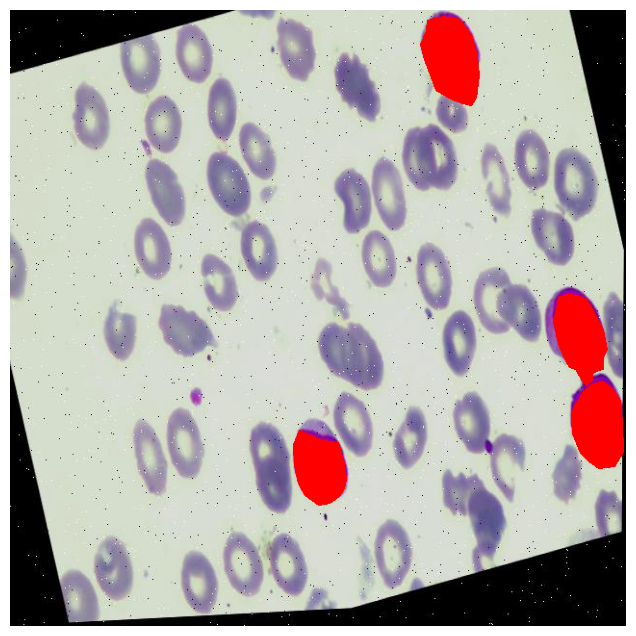

In [ ]:
img_path = selected_images[0]
label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
image, masks = load_image_with_masks(img_path, label_path)

for mask in masks:
    image[mask == 255] = [255,0,0]
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')

In [ ]:
results = model.predict(source=img_path)


image 1/1 /content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer/images/train/2785LAM30_jpeg.rf.60ef127103e216f94d791c8938d0fcfa.jpg: 640x640 4 1s, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)


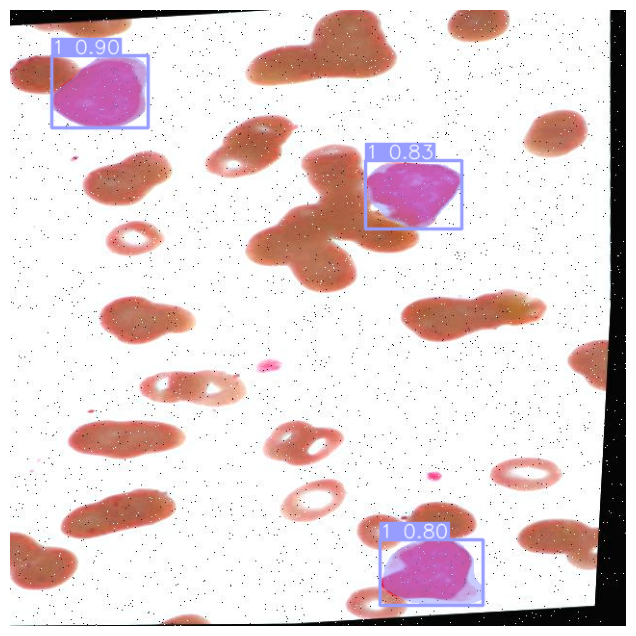

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(results[0].plot())
plt.axis("off")
plt.grid(False)

### Model Prediction sample 2

(-0.5, 639.5, 639.5, -0.5)

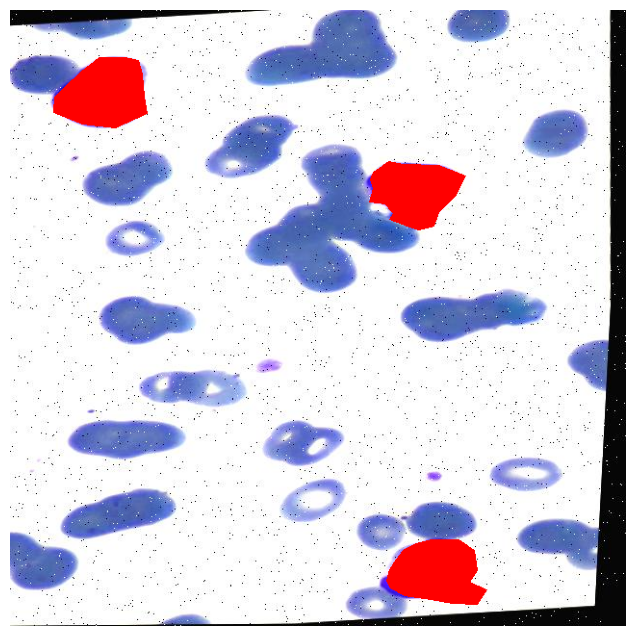

In [ ]:
img_path = selected_images[2]
label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
image, masks = load_image_with_masks(img_path, label_path)

for mask in masks:
    image[mask == 255] = [255,0,0]
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')


image 1/1 /content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer/images/train/2604LAM6_jpeg.rf.8f6ec73f8c847c03e87f9c9c02e19861.jpg: 640x640 3 1s, 22.1ms
Speed: 3.6ms preprocess, 22.1ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)


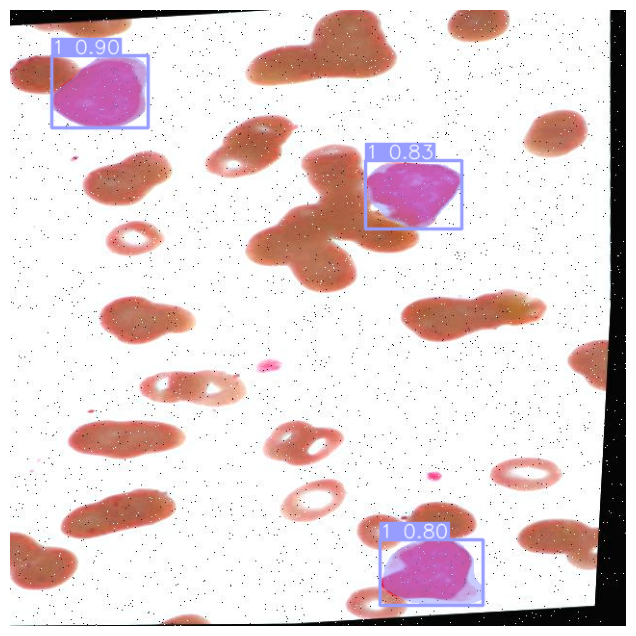

In [ ]:
results = model.predict(source=img_path)
plt.figure(figsize=(8,8))
plt.imshow(results[0].plot())
plt.axis("off")
plt.grid(False)

### Model prediction sample 3

(-0.5, 639.5, 639.5, -0.5)

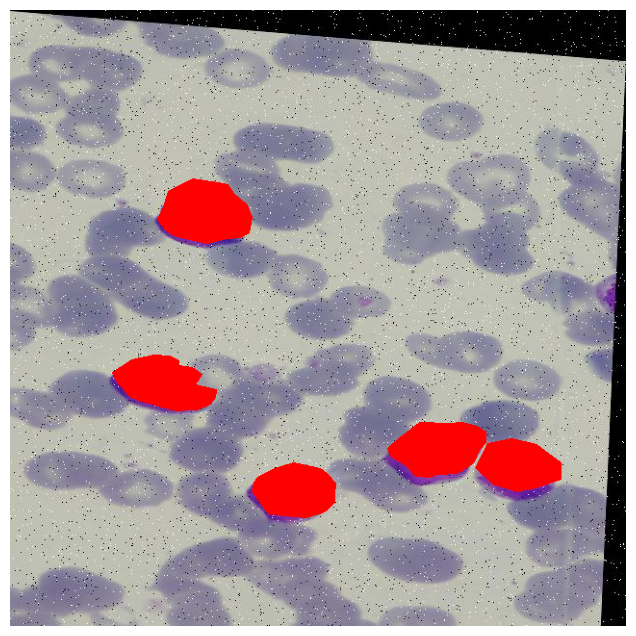

In [ ]:
img_path = selected_images[3]
label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
image, masks = load_image_with_masks(img_path, label_path)

for mask in masks:
    image[mask == 255] = [255,0,0]
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')


image 1/1 /content/drive/MyDrive/projects/blood_cancer_project/dataset/data_cancer/images/train/6927LALB2_jpeg.rf.f29a4b7ab7bc8b95115ef0bb72b443b1.jpg: 640x640 5 0s, 1 1, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)


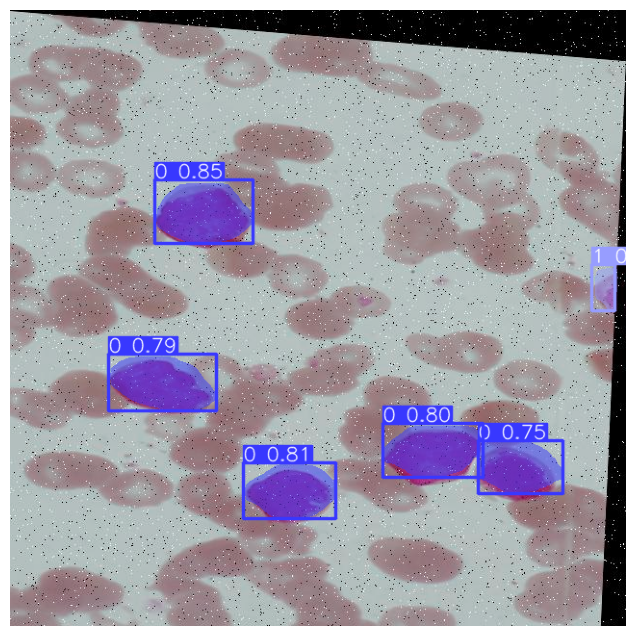

In [ ]:
results = model.predict(source=img_path)
plt.figure(figsize=(8,8))
plt.imshow(results[0].plot())
plt.axis("off")
plt.grid(False)

# Model Evaluations Plots

In [ ]:
PLOTS_PATH= 'runs/segment/train/'

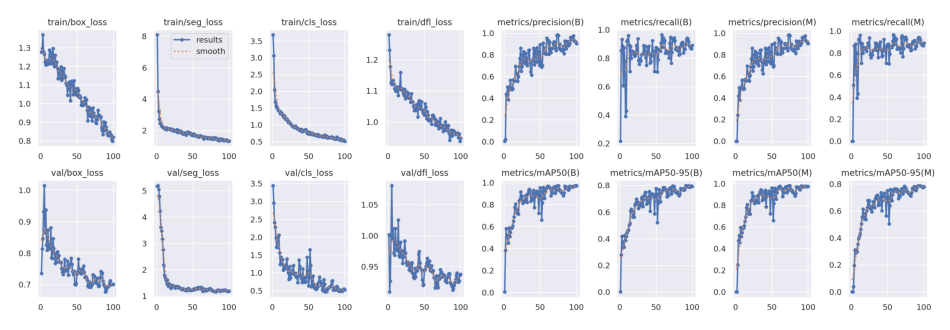

In [ ]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"results.png"))

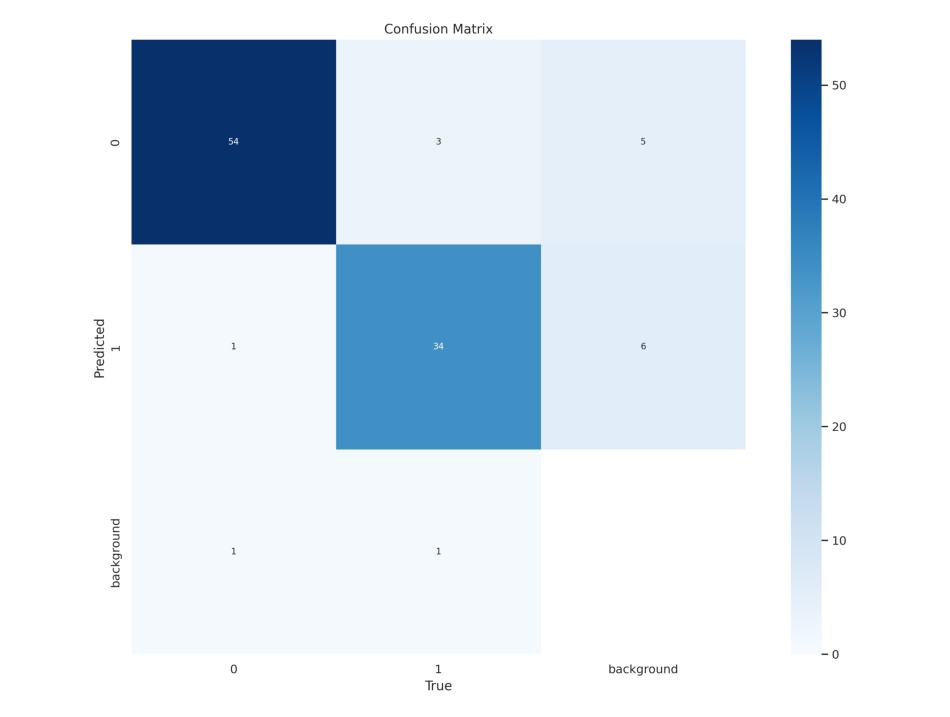

In [ ]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"confusion_matrix.png"))

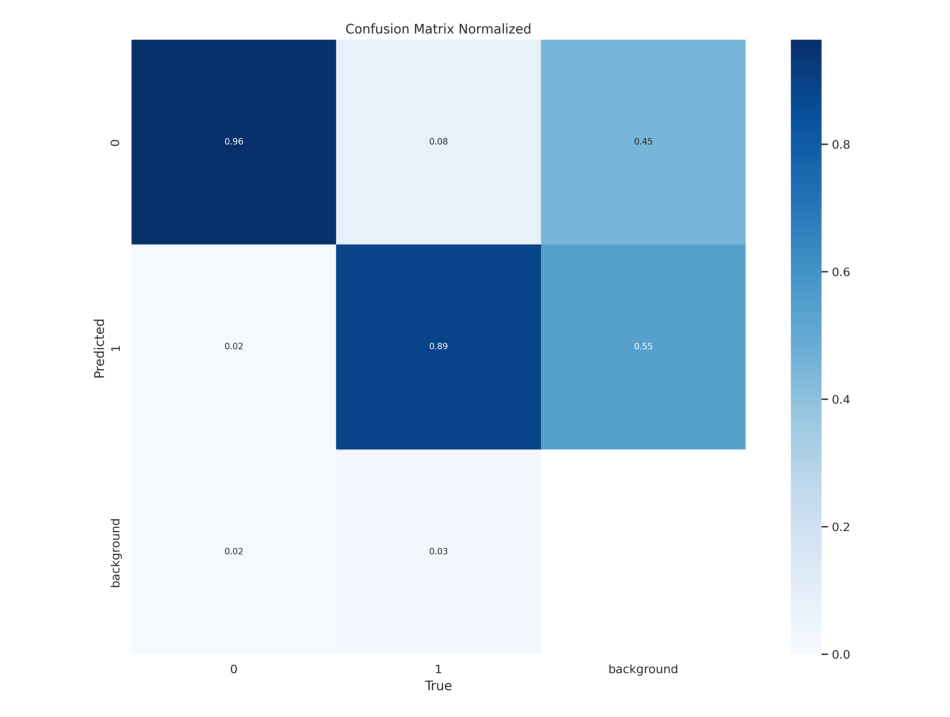

In [ ]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"confusion_matrix_normalized.png"))

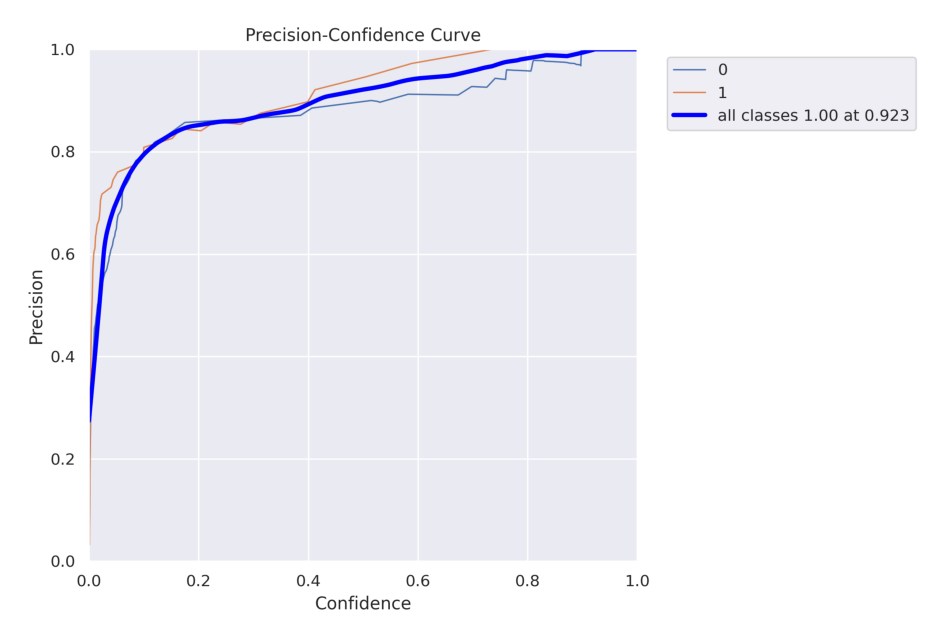

In [ ]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"MaskP_curve.png"))

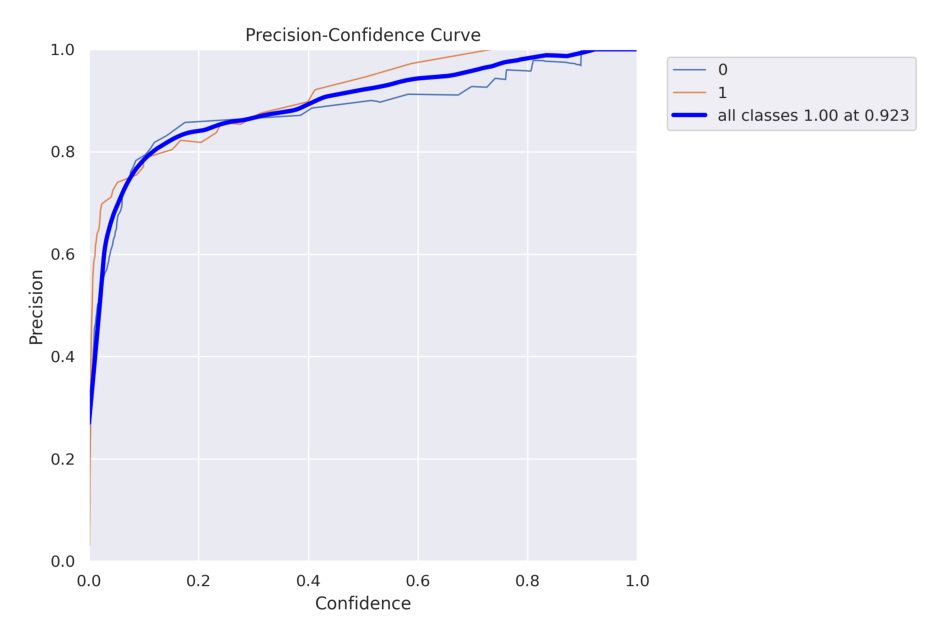

In [ ]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"BoxP_curve.png"))

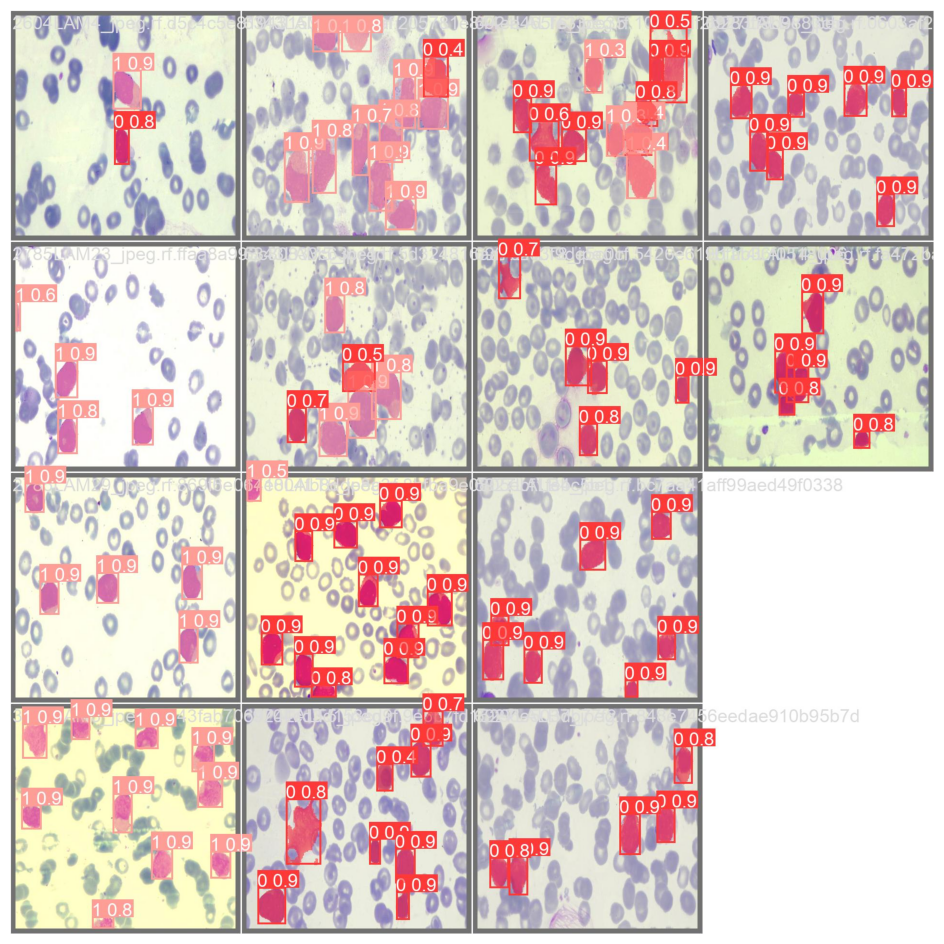

In [ ]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"val_batch0_pred.jpg"))